Of course. Here is a full, detailed notebook using the **LightGBM (LGBM)** model.

LGBM is an excellent choice. It's a gradient boosting model like XGBoost, but it's often significantly **faster** and can be **more accurate**.

We will use all the successful strategies from our XGBoost notebook:

1.  **Simple Features:** Use the 18 original features + 6 simple ratios.
2.  **Imbalance Handling:** Use LGBM's built-in `class_weight='balanced'` parameter.
3.  **Early Stopping:** To prevent overfitting and find the best number of trees.
4.  **Threshold Tuning:** The most important step. We will find the optimal probability threshold to maximize the **Macro F1-Score**.

-----

### 📝 Predict2Protect: LightGBM (LGBM) Notebook

This notebook builds a high-performance bankruptcy prediction model using `LGBMClassifier`, a fast and powerful alternative to XGBoost.

-----

### 1\. Setup: Install Libraries and Import Dependencies

This cell installs `lightgbm` and imports all necessary libraries.

In [1]:
# Install lightgbm


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from lightgbm import LGBMClassifier
import lightgbm as lgb # For the early stopping callback
# from google.colab import files # For downloading files

-----

### 2\. Load Data

This cell mounts your Google Drive to access your project files.

**Action Required:**

1.  Run the cell below and authorize your Google Account.
2.  Update the `file_path` variable to point to your `Predict2Protect` folder.

<!-- end list -->

In [50]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# --- IMPORTANT: UPDATE THIS PATH ---
# Example: "/content/drive/My Drive/Predict2Protect/"
file_path = "/content/drive/My Drive/Predict2Protect/"

# Load the datasets
try:
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    print("Datasets loaded successfully!")
except FileNotFoundError:
    print(f"Error: Files not found. Please check your 'file_path': {file_path}")

# Store test company names for the submission file
test_company_names = test_df['company_name']

Datasets loaded successfully!


-----

### 3\. Data Exploration & Preprocessing

We'll encode the target variable (`status_label`) and drop the unneeded index column.

In [52]:
print("--- Training Data Info ---")
train_df.info()

print("\n--- Target Variable Distribution ---")
print(train_df['status_label'].value_counts(normalize=True))

# Define the target variable 'y' and encode it
# 'failed' = 1 (our positive class)
# 'alive' = 0 (our negative class)
y = train_df['status_label'].map({'failed': 1, 'alive': 0})

# Define the features 'X'
X = train_df.drop(['status_label', 'Unnamed: 0'], axis=1)

# Also drop 'Unnamed: 0' from the test set
X_test = test_df.drop('Unnamed: 0', axis=1)

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62789 entries, 0 to 62788
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    62789 non-null  int64  
 1   company_name  62789 non-null  object 
 2   fyear         62789 non-null  float64
 3   status_label  62789 non-null  object 
 4   X1            62789 non-null  float64
 5   X2            62789 non-null  float64
 6   X3            62789 non-null  float64
 7   X4            62789 non-null  float64
 8   X5            62789 non-null  float64
 9   X6            62789 non-null  float64
 10  X7            62789 non-null  float64
 11  X8            62789 non-null  float64
 12  X9            62789 non-null  float64
 13  X10           62789 non-null  float64
 14  X11           62789 non-null  float64
 15  X12           62789 non-null  float64
 16  X13           62789 non-null  float64
 17  X14           62789 non-null  float64
 18 

-----

### 4\. Feature Engineering (Simple Ratios)

We will use the simple, proven feature set: the original 18 features plus 6 basic financial ratios. This avoids the noise that the time-series features introduced.

In [53]:
def create_financial_ratios(df):
    """Applies feature engineering to create simple financial ratios."""
    df_copy = df.copy() # Work on a copy

    # --- 1. Create original ratios ---
    df_copy['Current_Ratio'] = df_copy['X1'] / df_copy['X14'].replace(0, np.nan)
    df_copy['Debt_to_Assets'] = df_copy['X17'] / df_copy['X10'].replace(0, np.nan)
    df_copy['Debt_to_Equity'] = df_copy['X17'] / df_copy['X15'].replace(0, np.nan)
    df_copy['Net_Profit_Margin'] = df_copy['X6'] / df_copy['X9'].replace(0, np.nan)
    df_copy['Gross_Profit_Margin'] = df_copy['X13'] / df_copy['X9'].replace(0, np.nan)
    df_copy['ROA'] = df_copy['X6'] / df_copy['X10'].replace(0, np.nan)

    ratio_cols = [
        'Current_Ratio', 'Debt_to_Assets', 'Debt_to_Equity',
        'Net_Profit_Margin', 'Gross_Profit_Margin', 'ROA'
    ]
    # Replace inf/-inf with NaN, then fill all NaNs with 0
    df_copy[ratio_cols] = df_copy[ratio_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

    return df_copy

# Apply the feature engineering
print("Applying feature engineering (SIMPLE version)...")
X = create_financial_ratios(X)
X_test = create_financial_ratios(X_test)
print("Feature engineering complete.")

Applying feature engineering (SIMPLE version)...
Feature engineering complete.


-----

### 5\. Define Feature Groups

This cell lists our numerical and categorical features for the preprocessor.

In [54]:
# 1. Define feature lists

# Original numerical features
numerical_features = [f'X{i}' for i in range(1, 19)]

# Original engineered features
new_ratio_features = [
    'Current_Ratio', 'Debt_to_Assets', 'Debt_to_Equity',
    'Net_Profit_Margin', 'Gross_Profit_Margin', 'ROA'
]

# Combine all numerical features
all_numerical_features = numerical_features + new_ratio_features

# Categorical features
categorical_features = ['fyear', 'Division', 'MajorGroup']

print(f"Total numerical features: {len(all_numerical_features)}")
print(f"Total categorical features: {len(categorical_features)}")

Total numerical features: 24
Total categorical features: 3


-----

### 6\. Build the Preprocessing Pipeline

This pipeline object bundles all our preprocessing steps (`StandardScaler` for numbers, `OneHotEncoder` for categories).

In [55]:
# Create the transformer for numerical features
numerical_transformer = StandardScaler()

# Create the transformer for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create the ColumnTransformer to apply transformers to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, all_numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # This will drop 'company_name'
)

-----

### 7\. Define the LightGBM (LGBM) Model

Here we create our `LGBMClassifier`. We use `class_weight='balanced'` to handle imbalance and add some conservative hyperparameters that worked well for XGBoost.

In [56]:
import optuna
from sklearn.metrics import f1_score
import lightgbm as lgb
from lightgbm import LGBMClassifier

# We keep the preprocessor and pipeline definitions here
# so they are globally available for the final model.

# 1. Preprocessor (Unchanged)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, all_numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' 
)

# 2. Pipeline (Unchanged)
# We define the structure, but the params will be set by Optuna
base_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, n_jobs=-1)) # Basic model
])

# 3. Split data *once* here
# We use the same split for every trial for a fair comparison
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,       
    random_state=42,     
    stratify=y          
)

# 4. Pre-transform the data (saves a lot of time)
print("Pre-fitting preprocessor and transforming data...")
preprocessor.fit(X_train, y_train)
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
print("Data transformation complete.")


# --- Define the Optuna Objective Function for LGBM ---
def objective(trial):
    # --- 1. Define the Hyperparameter Search Space ---
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'n_estimators': 1000,
        'verbose': -1, # Suppress LGBM's own logs
        
        # --- This is the key: We are now tuning this parameter ---
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0), # Try values between 1 and 5
        
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }
    
    # --- 2. Create and Train the Model ---
    model = LGBMClassifier(
        **params, 
        random_state=42, 
        n_jobs=-1
    )
    
    model.fit(
        X_train_transformed, 
        y_train,
        eval_set=[(X_val_transformed, y_val)],
        callbacks=[lgb.early_stopping(50, verbose=False)] # Use LGBM's callback
    )
    
    # --- 3. Find Best Threshold for *this* trial ---
    y_proba_val = model.predict_proba(X_val_transformed)[:, 1]
    
    best_f1 = 0
    best_threshold = 0.5
    thresholds = np.arange(0.1, 0.6, 0.01)

    for t in thresholds:
        y_pred_tuned = (y_proba_val > t).astype(int) 
        f1 = f1_score(y_val, y_pred_tuned, average='macro') # Tune for Macro F1
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
            
    # --- 4. Store the threshold and return the score to maximize ---
    trial.set_user_attr('best_threshold', best_threshold) # Save the best threshold
    return best_f1 # Return the Macro F1-Score

Pre-fitting preprocessor and transforming data...
Data transformation complete.


In [57]:
# --- Run the Hyperparameter Search ---
# We tell Optuna to 'maximize' the Macro F1 score
# We need to install optuna if it's not already
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # This will run 50 different trials

# --- Get the Best Results ---
best_params = study.best_params
best_threshold = study.best_trial.user_attrs['best_threshold']
best_score = study.best_value

print("\n--- Optuna Search Complete ---")
print(f"Best Macro F1 Score: {best_score:.4f}")
print(f"Best Threshold: {best_threshold:.2f}")
print("\nBest Hyperparameters Found:")
print(best_params)

[I 2025-11-03 11:10:45,033] A new study created in memory with name: no-name-e45a4468-74b7-4f50-9016-492afee855d1
/Users/azizulhoque/miniforge3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-03 11:10:45,227] Trial 0 finished with value: 0.5966478606981276 and parameters: {'scale_pos_weight': 3.758366457626989, 'max_depth': 4, 'min_child_samples': 25, 'learning_rate': 0.07826486546616457, 'subsample': 0.9283460709601026, 'colsample_bytree': 0.7623976114726932, 'reg_alpha': 0.33843886740303053, 'reg_lambda': 0.503276848933671}. Best is trial 0 with value: 0.5966478606981276.
/Users/azizulhoque/miniforge3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-03 11:10:45,546] Trial 1 finished with value: 0.616421942


--- Optuna Search Complete ---
Best Macro F1 Score: 0.7038
Best Threshold: 0.26

Best Hyperparameters Found:
{'scale_pos_weight': 1.7353861917233042, 'max_depth': 6, 'min_child_samples': 10, 'learning_rate': 0.08451805989753479, 'subsample': 0.7428275627132285, 'colsample_bytree': 0.8912014739021233, 'reg_alpha': 0.3245356072060395, 'reg_lambda': 0.3684956350195392}


-----

### 9.5 (Critical) Find the Best Prediction Threshold

This cell finds the optimal probability cutoff to maximize the **Macro F1-Score**, our primary competition metric.

In [58]:
# --- Find the best prediction threshold for MACRO F1 ---

thresholds = np.arange(0.1, 0.6, 0.01)  # Test thresholds from 0.1 to 0.59
best_f1 = 0
best_threshold = 0.5

print("Finding best threshold to maximize MACRO F1-Score...")
for t in thresholds:
    # Apply new threshold
    y_pred_tuned = (y_proba_val > t).astype(int)

    # --- Calculate F1 for the 'macro avg' ---
    f1 = f1_score(y_val, y_pred_tuned, average='macro')

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\nBest Threshold Found: {best_threshold:.2f}")
print(f"This threshold gives MACRO F1 Score on Validation: {best_f1:.4f}")

# Print the full report with this new, optimized threshold
print("\n--- Validation Report (with Tuned Threshold) ---")
y_pred_best_threshold = (y_proba_val > best_threshold).astype(int)
print(classification_report(y_val, y_pred_best_threshold, target_names=['alive', 'failed']))

Finding best threshold to maximize MACRO F1-Score...

Best Threshold Found: 0.59
This threshold gives MACRO F1 Score on Validation: 0.6519

--- Validation Report (with Tuned Threshold) ---
              precision    recall  f1-score   support

       alive       0.97      0.89      0.93     11717
      failed       0.28      0.59      0.38       841

    accuracy                           0.87     12558
   macro avg       0.62      0.74      0.65     12558
weighted avg       0.92      0.87      0.89     12558



-----

### 10\. Final Training and Submission File Generation

Now we re-train our model on the *full* dataset. We use the `best_iteration_count` as our `n_estimators` to prevent overfitting. We then use our `best_threshold` to make the final predictions.

In [59]:
print("Training final model on ALL training data...")

# --- 1. Get the best params from the Optuna study ---
final_params = best_params.copy() 

# --- 2. Get the best iteration count from a new model ---
# We need to find the best n_estimators for the *full* dataset
# We do a quick retrain on the validation split with early stopping
temp_model = LGBMClassifier(
    **final_params, 
    random_state=42, 
    n_jobs=-1,
    n_estimators=1000
)
temp_model.fit(
    X_train_transformed, 
    y_train,
    eval_set=[(X_val_transformed, y_val)],
    callbacks=[lgb.early_stopping(50, verbose=False)]
)
best_iteration_count = temp_model.best_iteration_
print(f"Using {best_iteration_count} estimators for final model.")


# --- 3. Define the final model with best params ---
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor), # Use the pre-fit preprocessor
    ('classifier', LGBMClassifier(
        **final_params,
        random_state=42,
        n_jobs=-1,
        n_estimators=best_iteration_count, # Use best iteration
    ))
])

# Fit on ALL data (X, y)
final_model.fit(X, y) 
print("Final model training complete.")

# --- 4. Make Predictions using the Best Threshold ---
print("Making predictions on test.csv...")
test_probabilities = final_model.predict_proba(X_test)[:, 1]

# Apply the best threshold found by Optuna
test_predictions_encoded = (test_probabilities > best_threshold).astype(int)
# --- End of fix ---

# Decode the predictions (0 -> 'alive', 1 -> 'failed')
test_predictions_decoded = pd.Series(test_predictions_encoded).map({0: 'alive', 1: 'failed'})

# --- Aggregate predictions for unique companies ---
temp_df = pd.DataFrame({
    'company_name': test_company_names,
    'status_label': test_predictions_decoded
})

def aggregate_status(labels):
    if 'failed' in labels.values:
        return 'failed'
    return 'alive'

# --- FIX: Removed the extra dot before .apply ---
final_status = temp_df.groupby('company_name', sort=False)['status_label'].apply(aggregate_status)
submission_df = final_status.reset_index()
# --- End of aggregation ---

print("\n--- Submission File Head (Original Order) ---")
print(submission_df.head())

Training final model on ALL training data...
Using 974 estimators for final model.
Final model training complete.
Making predictions on test.csv...

--- Submission File Head (Original Order) ---
  company_name status_label
0          C_3        alive
1          C_4        alive
2          C_6        alive
3          C_8        alive
4         C_17        alive


/Users/azizulhoque/miniforge3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


-----

### 11\. (Optional) Evaluate Submission Against Ground Truth

If you have your `test_labels.csv` file, this cell will load it, process it, and give you a final, definitive score on your new LGBM submission.

Successfully loaded ground truth file: real_test.csv

--- Final Evaluation Report (Submission vs. Ground Truth) ---
Macro F1 Score (6 Decimals): 0.621452
              precision    recall  f1-score   support

       alive       0.95      0.97      0.96      1673
      failed       0.36      0.24      0.29       122

    accuracy                           0.92      1795
   macro avg       0.65      0.60      0.62      1795
weighted avg       0.91      0.92      0.91      1795


--- Final Confusion Matrix (Submission vs. Ground Truth) ---


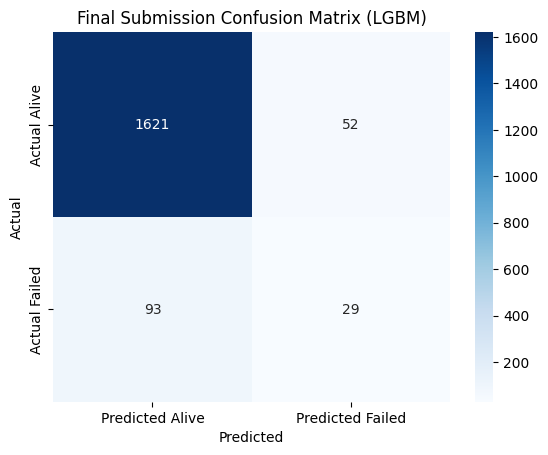

In [60]:
# --- 1. SET YOUR GROUND TRUTH FILENAME ---
ground_truth_filename = "real_test.csv" # <-- UPDATE THIS IF NEEDED

try:
    real_test_df = pd.read_csv(ground_truth_filename)
    print(f"Successfully loaded ground truth file: {ground_truth_filename}")

    # --- 2. Process the Ground Truth File ---
    def aggregate_status_truth(labels):
        if 'failed' in labels.values:
            return 'failed'
        return 'alive'

    true_labels_agg = real_test_df.groupby('company_name')['status_label'].apply(aggregate_status_truth).reset_index()
    true_labels_agg.columns = ['company_name', 'true_label']

    # --- 3. Merge Predictions with True Labels ---
    # 'submission_df' is in memory from Cell 10
    submission_df_renamed = submission_df.rename(columns={'status_label': 'predicted_label'})
    eval_df = pd.merge(true_labels_agg, submission_df_renamed, on='company_name', how='left')

    # --- 4. Calculate and Print All Metrics ---
    print("\n--- Final Evaluation Report (Submission vs. Ground Truth) ---")
    y_true = eval_df['true_label']
    y_pred = eval_df['predicted_label']

    # --- NEW: Calculate and print Macro F1 separately ---
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1 Score (6 Decimals): {macro_f1:.6f}")

    print(classification_report(y_true, y_pred, target_names=['alive', 'failed']))

    # --- 5. Display Confusion Matrix ---
    print("\n--- Final Confusion Matrix (Submission vs. Ground Truth) ---")
    cm = confusion_matrix(y_true, y_pred, labels=['alive', 'failed'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Alive', 'Predicted Failed'],
                yticklabels=['Actual Alive', 'Actual Failed'])
    plt.title('Final Submission Confusion Matrix (LGBM)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

except FileNotFoundError:
    print(f"\nGround truth file not found at: {ground_truth_filename}")
    print("Skipping final evaluation. Your submission file is still ready.")
except Exception as e:
    print(f"An error occurred during final evaluation: {e}")

-----

### 12\. Download Submission File

This final cell saves your `submission.csv` file and downloads it to your computer.

In [61]:
# Save the file
submission_file_name = "submission_lgbm.csv"
submission_df.to_csv(submission_file_name, index=False)

print(f"\n'{submission_file_name}' created successfully.")



'submission_lgbm.csv' created successfully.
